## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib

In [ ]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit

# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constants
E = 19300e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
h = 100  # Isotropic hardening rate


# Generate strain history
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    alpha, eps_p, delta_gamma = 0, 0, 0
    
    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

        # Store the data
        dataset.append([
            E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, delta_gamma
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [2]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [3]:
columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cumulative_plastic_strain", "alpha", 'sign','plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [4]:
df[300:350]

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
300,1.930000e+10,150000000.0,100.0,-1.930000e+06,0.0299,1.480700e+08,0.022228,0.022228,1.0,0.0
301,1.930000e+10,150000000.0,100.0,-3.860000e+06,0.0298,1.461400e+08,0.022228,0.022228,1.0,0.0
302,1.930000e+10,150000000.0,100.0,-5.790000e+06,0.0297,1.442100e+08,0.022228,0.022228,1.0,0.0
303,1.930000e+10,150000000.0,100.0,-7.720000e+06,0.0296,1.422800e+08,0.022228,0.022228,1.0,0.0
304,1.930000e+10,150000000.0,100.0,-9.650000e+06,0.0295,1.403500e+08,0.022228,0.022228,1.0,0.0
305,1.930000e+10,150000000.0,100.0,-1.158000e+07,0.0294,1.384200e+08,0.022228,0.022228,1.0,0.0
306,1.930000e+10,150000000.0,100.0,-1.351000e+07,0.0293,1.364900e+08,0.022228,0.022228,1.0,0.0
307,1.930000e+10,150000000.0,100.0,-1.544000e+07,0.0292,1.345600e+08,0.022228,0.022228,1.0,0.0
308,1.930000e+10,150000000.0,100.0,-1.737000e+07,0.0291,1.326300e+08,0.022228,0.022228,1.0,0.0
309,1.930000e+10,150000000.0,100.0,-1.930000e+07,0.0290,1.307000e+08,0.022228,0.022228,1.0,0.0


In [5]:
save_dataset_to_csv(training)

Dataset saved to generated_dataset_von_mises_training_07_01_2025.csv


In [6]:
df.head(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
0,1.930000e+10,150000000.0,100.0,-148070000.0,0.0001,1930000.0,0.0,0.0,1.0,0.0
1,1.930000e+10,150000000.0,100.0,-146140000.0,0.0002,3860000.0,0.0,0.0,1.0,0.0
2,1.930000e+10,150000000.0,100.0,-144210000.0,0.0003,5790000.0,0.0,0.0,1.0,0.0
3,1.930000e+10,150000000.0,100.0,-142280000.0,0.0004,7720000.0,0.0,0.0,1.0,0.0
4,1.930000e+10,150000000.0,100.0,-140350000.0,0.0005,9650000.0,0.0,0.0,1.0,0.0
5,1.930000e+10,150000000.0,100.0,-138420000.0,0.0006,11580000.0,0.0,0.0,1.0,0.0
6,1.930000e+10,150000000.0,100.0,-136490000.0,0.0007,13510000.0,0.0,0.0,1.0,0.0
7,1.930000e+10,150000000.0,100.0,-134560000.0,0.0008,15440000.0,0.0,0.0,1.0,0.0
8,1.930000e+10,150000000.0,100.0,-132630000.0,0.0009,17370000.0,0.0,0.0,1.0,0.0
9,1.930000e+10,150000000.0,100.0,-130700000.0,0.0010,19300000.0,0.0,0.0,1.0,0.0


In [7]:
df.tail(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
1450,1.930000e+10,150000000.0,100.0,1930000.0,0.0251,1.500000e+08,0.017328,0.10624,1.0,0.0001
1451,1.930000e+10,150000000.0,100.0,1930000.0,0.0252,1.500000e+08,0.017428,0.10634,1.0,0.0001
1452,1.930000e+10,150000000.0,100.0,1930000.0,0.0253,1.500000e+08,0.017528,0.10644,1.0,0.0001
1453,1.930000e+10,150000000.0,100.0,1930000.0,0.0254,1.500000e+08,0.017628,0.10654,1.0,0.0001
1454,1.930000e+10,150000000.0,100.0,1930000.0,0.0255,1.500000e+08,0.017728,0.10664,1.0,0.0001
1455,1.930000e+10,150000000.0,100.0,1930000.0,0.0256,1.500000e+08,0.017828,0.10674,1.0,0.0001
1456,1.930000e+10,150000000.0,100.0,1930000.0,0.0257,1.500000e+08,0.017928,0.10684,1.0,0.0001
1457,1.930000e+10,150000000.0,100.0,1930000.0,0.0258,1.500000e+08,0.018028,0.10694,1.0,0.0001
1458,1.930000e+10,150000000.0,100.0,1930000.0,0.0259,1.500000e+08,0.018128,0.10704,1.0,0.0001
1459,1.930000e+10,150000000.0,100.0,1930000.0,0.0260,1.500000e+08,0.018228,0.10714,1.0,0.0001


In [8]:
strain_training= training[:,-6]
strain_test1= test1[:,-6]
strain_test2= test2[:,-6]

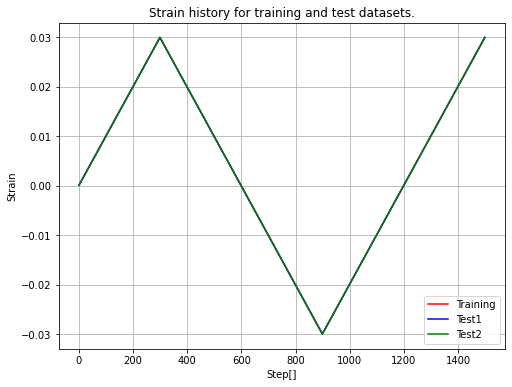

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [10]:
sign_training= training[:,-2]
sign_test1= test1[:,-2]
sign_test2= test2[:,-2]

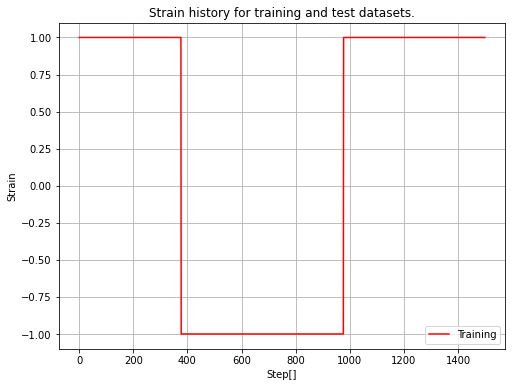

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(sign_training, label='Training', color='red')
#plt.plot(sign_test1, label='Test1', color='blue')
#plt.plot(sign_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [58]:
cm_plastic_strain_training= training[:,-4]
cm_plastic_strain_test1= test1[:,-4]
cm_plastic_strain_test2= test2[:,-4]

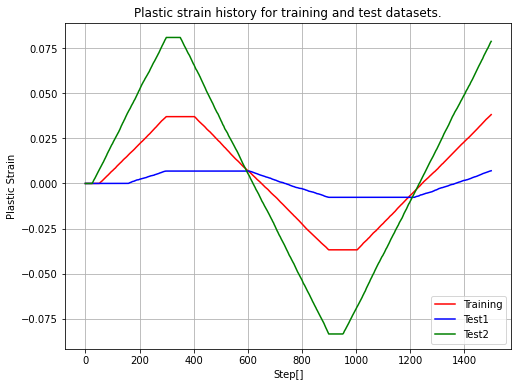

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(cm_plastic_strain_training, label='Training', color='red')
plt.plot(cm_plastic_strain_test1, label='Test1', color='blue')
plt.plot(cm_plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [60]:
plastic_strain_training= training[:,-1]
plastic_strain_test1= test1[:,-1]
plastic_strain_test2= test2[:,-1]

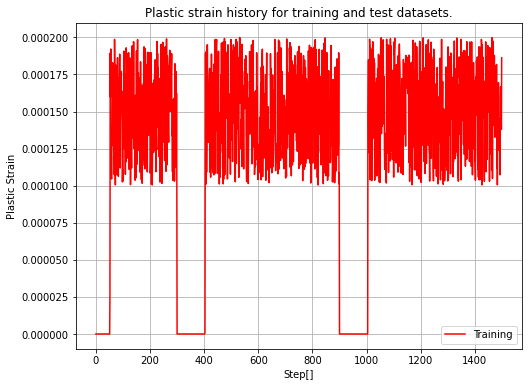

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
#plt.plot(plastic_strain_test1, label='Test1', color='blue')
#plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [62]:
alpha_training= training[:,-3]
alpha_test1= test1[:,-3]
alpha_test2= test2[:,-3]

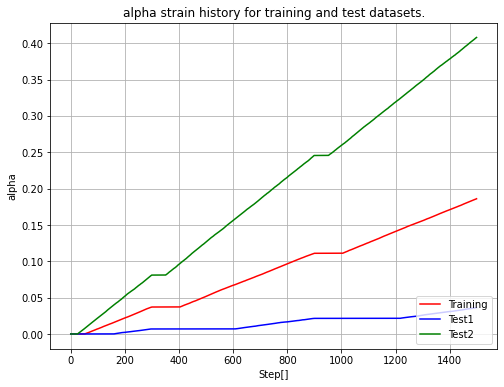

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_training, label='Training', color='red')
plt.plot(alpha_test1, label='Test1', color='blue')
plt.plot(alpha_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('alpha')
plt.title('alpha strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [64]:
print(np.isnan(training).any())
print(np.isinf(training).any())

False
False


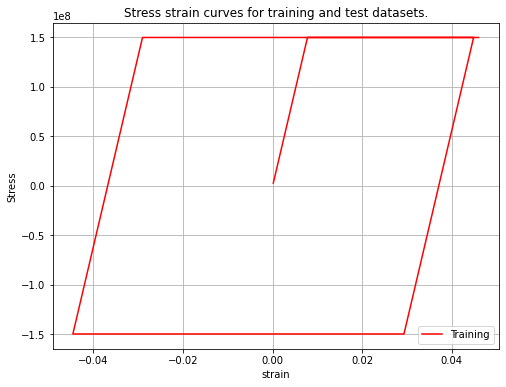

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()